In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as mplcolors
import numpy as np
from scipy import constants, interpolate
from pytmatrix.tmatrix import Scatterer
from pytmatrix import tmatrix_aux, psd, orientation, radar, tmatrix_aux, refractive
import numpy as np
from scipy.integrate import quad
from scipy.stats import linregress
import pyart 
import glob, os
from scipy.io import loadmat
from datetime import timedelta, datetime
import matplotlib.cm as cm
import template
import matplotlib as mpl
from shapely import geometry, Polygon
from pyproj import Geod
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import pickle
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed
from itertools import product
import multiprocessing as mp
from tqdm.auto import tqdm
import pickle
from itertools import product


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
class m_agg(object):
    """
    Class for retrieving the effective complex refractive index of a mixture of ice and air using Maxwell-Garnett
    """
    def __init__(self, a = 0.178, b = -0.922, e_a = 1.00059+0j, lam = tmatrix_aux.wl_S):
        self.a = float(a)
        self.b = float(b)
        self.wl = float(lam)
        self.e_a = complex(e_a)

    def __call__(self, D):
        rho_agg = self.a*D**self.b
        f_i = rho_agg/0.917
        return refractive.mg_refractive((refractive.mi(self.wl, 0.2), self.e_a), (f_i, 1-f_i))
        return refractive.mi(self.wl, self.a*D**self.b)

class expPSD(object):
    """
    Exponential PSD class
    """
    def __init__(self, N0=2e4, D0=0.7):
        self.D0 = float(D0)
        self.N0 = float(N0)

    def __call__(self, D):
        return self.N0*np.exp(-3.67*(D)/self.D0)

class gammaPSD(object):
    """
    Gamma PSD class
    """
    def __init__(self, N0=5.9e12, mu=2.04, lam=2.26e4):
        self.mu = float(mu)
        self.lam = float(lam)
        self.N0 = float(N0)

    def __call__(self, D):
        return self.N0*D**self.mu*np.exp(-self.lam*D)

class gamma_plate(object):
    """
    Exagonal plates axis ratio (Um et al., 2015):

    gamma = aD^b/D
    """
    def __init__(self, a = 1.07, b = 0.778):
        self.a = float(a)
        self.b = float(b)

    def __call__(self, D):
        gamma = (self.a*(D*1e3)**(self.b))/(D*1e3)
        return gamma

class gamma_column(object):
    """
    Column axis ratio (Um et al., 2015)

    gamma = D/aD^b
    """
    def __init__(self, a = 0.85, b = 0.958):
        self.a = float(a)
        self.b = float(b)

    def __call__(self, D):
        gamma = (D*1e3)/(self.a*(D*1e3)**(self.b))

        return gamma

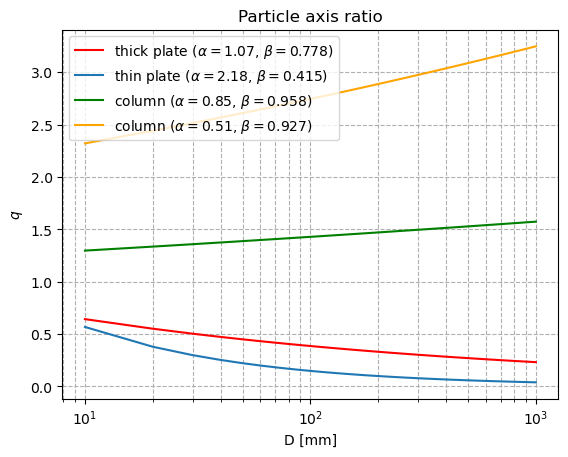

In [3]:
# plots axis ratios for sanity check
D = np.linspace(10, 1000, 100)

ga = gamma_exagonal()
plt.semilogx(D,[ga(d*1e-3) for d in D], label = r'thick plate ($\alpha=1.07$, $\beta=0.778$)', color='red')
ga = gamma_exagonal(2.18, 0.415)
plt.semilogx(D,[ga(d*1e-3) for d in D], label = r'thin plate ($\alpha=2.18$, $\beta=0.415$)')
ga = gamma_column(0.85, 0.958)
plt.semilogx(D,[ga(d*1e-3) for d in D], label = r'column ($\alpha=0.85$, $\beta=0.958$)', color='green')
ga = gamma_column(0.51, 0.927)
plt.semilogx(D,[ga(d*1e-3) for d in D], label = r'column ($\alpha=0.51$, $\beta=0.927$)', color='orange')

plt.xlabel('D [mm]')
plt.ylabel(r'$q$')
plt.legend()
plt.grid(which='both', ls = '--')
plt.title('Particle axis ratio')

plt.savefig('q.png', dpi=300, bbox_inches='tight')

In [4]:
# get indexes of refraction of low-density and high density ice at X-, C-, and S-band.

m_ice  = [refractive.mi(lam, 0.917) for lam in [tmatrix_aux.wl_X, tmatrix_aux.wl_C, tmatrix_aux.wl_S]]
m_tup  = [(m_i,1) for m_i in m_ice]
m_mg_ai  = [refractive.mg_refractive(m,(0.9, 0.1)) for m in m_tup]

In [5]:
#little sanity check

D_0 = np.arange(0.3, 0.8, 0.1)
N_0 = np.arange(2e4, 2.2e5, 2e4)

scatterer = Scatterer(wavelength=tmatrix_aux.wl_S, m=m_ice[2], ndgs=34)
scatterer.psd_integrator = psd.PSDIntegrator()
ga = gamma_exagonal(2.18, 0.415)
scatterer.psd_integrator.axis_ratio_func = lambda D: 1/ga(D)
scatterer.psd_integrator.D_max = 1
scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)

scatterer.or_pdf = orientation.gaussian_pdf(1, 89)
scatterer.orient = orientation.orient_averaged_fixed
scatterer.psd_integrator.init_scatter_table(scatterer)
scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
scatterer.psd = expPSD(N_0[-1], D_0[-1])
radar.Kdp(scatterer)

-0.6630966441371888

Text(0, 0.5, 'N(D) [m$^{-3}$ mm$^{-1}$]')

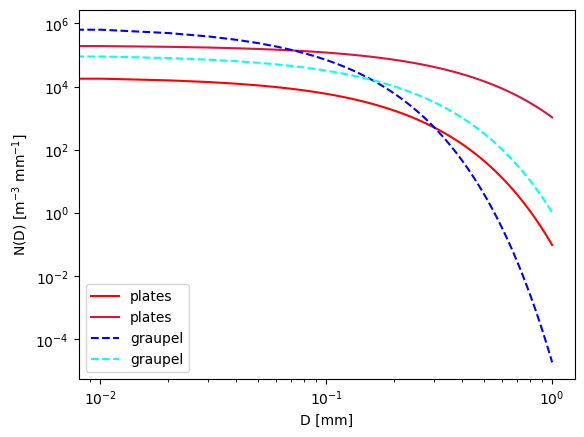

In [6]:
# plot some ice crystal and graupel PSDs

ga=expPSD(2e4, 0.3)
plt.loglog(np.linspace(0, 1, 100), ga(np.linspace(0, 1, 100)), label = 'plates', color='red')
ga=expPSD(2e5, 0.7)
plt.loglog(np.linspace(0, 1, 100), ga(np.linspace(0, 1, 100)), label = 'plates', color='crimson')
gr = expPSD(8e5, 1.5)
plt.loglog(np.linspace(0, 1, 100), gr(np.linspace(0, 10, 100)), label = 'graupel', ls = '--', color='blue')
gr = expPSD(1e5, 3.2)
plt.loglog(np.linspace(0, 1, 100), gr(np.linspace(0, 10, 100)), label = 'graupel', ls = '--', color='cyan')
plt.legend()

plt.xlabel('D [mm]')
plt.ylabel(r'N(D) [m$^{-3}$ mm$^{-1}$]')

In [7]:
def l(w, alpha=1.78, beta=0.475):
    """
    Function to retrieve the height of ice crystals following Um et al.(2015) parameters.

    Parameters
    ----------
    w: array-like.
        Width in micrometers.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
        
    Returns
    -------
    h: ndarray
        The corresponding heights in micrometers
    """
    
    return alpha*w**beta

def w(l, alpha=0.85, beta=0.958):
    """
    Function to retrieve the width of ice crystals following Um et al.(2015) parameters.

    Parameters
    ----------
    l: array-like.
        Length in micrometers.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
        
    Returns
    -------
    w: ndarray
        The corresponding widths in micrometers
    """
    
    return alpha*l**(beta)

def L_ab_ob(d, alpha, beta):
    """
    Retrieves the shape factors for oblate spheroids as in Lamb (1932).

    Parameters
    ----------
    d: array-like.
        diameter of the major axis.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
        
    Returns
    -------
    alpha_0: ndarray.
        The corresponding alpha_0.
    gamma_0: ndarray.
        The corresponding alpha_0.
    """
    
    c=l(d, alpha, beta)
    q=c/d
    e = np.sqrt(1 - q**2)
    alpha_0 = (np.sqrt(1-e**2)/e**3)*np.arcsin(e)-(1-e**2)/e**2
    gamma_0 = (2/e**2)*((1-np.sqrt(1-e**2)*np.arcsin(e)/e**2))
    
    return alpha_0, gamma_0

def L_ab_pr(d, alpha, beta):
    """
    Retrieves the shape factors for prolate spheroids as in Lamb (1932).

    Parameters
    ----------
    d: array-like.
        diameter of the major axis.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
        
    Returns
    -------
    alpha_0: ndarray.
        The corresponding alpha_0.
    gamma_0: ndarray.
        The corresponding alpha_0.
    """
    
    c=w(d, alpha, beta)
    q=d/c
    e = np.sqrt(1 - 1/q**2)
    alpha_0 = ((2*(1-e**2)/e**3)*(0.5*np.log((1+e)/(1-e))-e))
    gamma_0 = (1/e**2)-((1-2*e**2)/2*e**3)*np.log((1+e)/(1-e))

    return alpha_0, gamma_0

def f_ob(d, alpha, beta):
    """
    f function for oblate spheroids as in Weinheimer and Few (1987).

    Parameters
    ----------
    d: array-like.
        diameter of the major axis.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
        
    Returns
    -------
    f: ndarray.
        f values for oblate spheroids.
    """
    
    e_r = 100
    c = l(d, alpha, beta)
    q = c/d
    f = (2/3)*np.divide(q*(e_r-1)**2*np.abs(L_ab_ob(d, alpha, beta)[0]-L_ab_ob(d, alpha, beta)[1]), (2+(e_r-1)*L_ab_ob(d, alpha, beta)[0])*(2+(e_r-1)*L_ab_ob(d, alpha, beta)[1]))
    return f

def f_pr(d, alpha, beta):
    """
    f function for prolate spheroids as in Weinheimer and Few (1987).

    Parameters
    ----------
    d: array-like:
        diameter of the major axis.
    alpha: int or float:
        Alpha parameter.
    beta: int or float:
        beta parameter.
        
    Returns
    -------
    f: ndarray.
        f values for prolate spheroids.
    """
    
    e_r = 100
    c = w(d, alpha, beta)
    q = d/c
    f = (2/3)*np.divide(q*(e_r-1)**2*np.abs(L_ab_pr(d, alpha, beta)[0]-L_ab_pr(d, alpha, beta)[1]), (2+(e_r-1)*L_ab_pr(d, alpha, beta)[0])*(2+(e_r-1)*L_ab_pr(d, alpha, beta)[1]))
    f = f/q**3

    return f

def PE(E, d, f):
    """
    Electric potential energy as in Weinheimer and Few (1987) and Foster and Hallet (2002).

    Parameters
    ----------
    E: array-like.
        Electric field intensity in V/m.
    d: array-like.
        diameter of the major axis.
    f: array-like.
        f function.
        
    Returns
    -------
    PE: ndarray.
        The corresponding electrical potential energy.
    """
    
    e_0 = 8.85418782e-12
    return (np.pi/2)*e_0*f*E**2*(d*1e-6/2)**3
    
def PA_ob(d, alpha, beta):
    """
    Aerodynamic potential energy for oblate spheroids as in Weinheimer and Few (1987) and Foster and Hallet (2002).

    Parameters
    ----------
    E: array-like.
        Electric field intensity in V/m.
    alpha: int or float:
        Alpha parameter.
    beta: int or float:
        beta parameter.
        
    Returns
    -------
    PA: ndarray.
        The corresponding aerodynamic potential energy for oblate spheroids.
    """
    c=l(d, alpha, beta)
    q=c/d
    U = (d*1e-6/2)*(c*1e-6/2)*np.pi*9.8*(refractive.ice_density*1000)/(8*1.6e-5)
    k_x = L_ab_ob(d, alpha, beta)[0]/(2-L_ab_ob(d, alpha, beta)[0])
    k_z = L_ab_ob(d, alpha, beta)[1]/(2-L_ab_ob(d, alpha, beta)[1])
    H=4/3*q*np.abs(k_x-k_z)
    return (np.pi/8)*0.69*(U)**2*(d*1e-6)**3*H

def PA_pr(d, alpha, beta):
    """
    Aerodynamic potential energy for prolate spheroids as in Weinheimer and Few (1987) and Foster and Hallet (2002).

    Parameters
    ----------
    d: array-like.
        diameter of the major axis.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.

    Returns
    -------
    PA: ndarray.
        The corresponding aerodynamic potential energy for oblate spheroids.
    """
    
    c=w(d, alpha, beta)
    q=d/c
    U = (d*1e-6/2)*(c*1e-6/2)*np.pi*9.8*(refractive.ice_density*1000)/(8*1.6e-5)
    k_x = L_ab_pr(d, alpha, beta)[0]/(2-L_ab_pr(d, alpha, beta)[0])
    k_z = L_ab_pr(d, alpha, beta)[1]/(2-L_ab_pr(d, alpha, beta)[1])
    H=4/3*q*np.abs(k_x-k_z)
    H=H/q**3
    return (np.pi/8)*0.69*(U)**2*(d*1e-6)**3*H

def P_ob(PE, PA, b, T, theta):
    """
    Canting PDF for oblate spheroids as in Foster and Hallet (2002).

    Parameters
    ----------
    PE: array-like.
        Electrical potential energy for oblate spheroids.
    PA: array-like.
        Aerodynamic potential energy for oblate spheroids.
    beta: int or float.
        normalization parameter.

    Returns
    -------
    P: ndarray.
        The corresponding oblate spheroid orientation PDF.
    """
    
    k = 1.380649e-23
    P_theta = b*np.exp(-(PE*np.cos(np.deg2rad(theta))**2 + PA*np.sin(np.deg2rad(theta))**2)/(k*T))
    return P_theta

def P_pr(PE, PA, b, T, theta):
    """
    Canting PDF for oblate spheroids as in Foster and Hallet (2002).

    Parameters
    ----------
    PE: array-like.
        Electrical potential energy for oblate spheroids.
    PA: array-like.
        Aerodynamic potential energy for oblate spheroids.
    beta: int or float.
        normalization parameter.

    Returns
    -------
    P: ndarray.
         The corresponding prolate spheroid orientation PDF.
    """
    k = 1.380649e-23
    P_theta = b*np.exp(-(PE*np.sin(np.deg2rad(theta))**2 + PA*np.cos(np.deg2rad(theta))**2)/(k*T))
    return P_theta

def get_b(pdf):
    """
    Estimates the b constant of the PDF as in Foster and Hallet (2002).

    Parameters
    ----------
    pdf: array-like.
        The canting distribution PDF.

    Returns
    -------
    b: float.
         The normalization constant.
    """

    result = np.sum(np.mean(pdf, 0)) 
    b = 1 / result

    return b

def get_canting(pdf, angles):  
    """
    Gets the mean and standard deviation of the canting angle PDF.

    Parameters
    ----------
    pdf: array-like.
        The canting distribution PDF.
    angles: array-like.
        The range of PDF angles.

    Returns
    -------
    alpha: float.
         The mean canting angle.
    std: float.
        The canting angle standard deviation.
    """
    alpha = np.sum(pdf*angles)
    std = np.sqrt(np.sum((angles-alpha)**2*pdf))

    return std, alpha

In [8]:
# set the range of angles, diameters and electric field intensities.
angles = np.linspace(0, 90, 180)
D = np.arange(10, 1010, 10)
#E = np.array([0, 500, 1e3, 2e3, 3e3, 4e3, 5e3, 10e3, 20e3, 30e3, 50e3, 75e3, 100e3]) # This is for Figure 1
E = np.linspace(0, 100e3, 1000)

# Precompute f values
f_plates = f_ob(D, 2.18, 0.415)
f_thick = f_ob(D, 1.07, 0.778)
f_columns1 = f_pr(D, 0.85, 0.958)
f_columns2 = f_pr(D, 0.51, 0.927)

# Define the computation function for one combination of (e, d, f, pa_func, p_func, args)
def compute_pdf(args):
    e, d, f, pa_func, p_func, pa_args = args
    pa = pa_func(d, *pa_args)
    pe = PE(e, d, f)
    return [p_func(pe, pa, 1, 258, t) for t in angles]

# Create input argument lists
def create_args(E, D, f_values, pa_func, p_func, pa_args):
    return [(e, d, f, pa_func, p_func, pa_args) for e in E for d, f in zip(D, f_values)]

args1 = create_args(E, D, f_plates, PA_ob, P_ob, (2.18, 0.415))
args2 = create_args(E, D, f_thick, PA_ob, P_ob, (1.07, 0.778))
args3 = create_args(E, D, f_columns1, PA_pr, P_pr, (0.85, 0.958))
args4 = create_args(E, D, f_columns2, PA_pr, P_pr, (0.51, 0.927))

# Run in parallel
with ProcessPoolExecutor() as executor:
    ak = list(executor.map(compute_pdf, args1))
    ak2 = list(executor.map(compute_pdf, args2))
    ak3 = list(executor.map(compute_pdf, args3))
    ak4 = list(executor.map(compute_pdf, args4))

In [9]:
# reshape the canting angles pdfs

pdfs = np.asarray(ak).reshape(len(E), len(D), 180) 
pdfs2 = np.asarray(ak2).reshape(len(E), len(D), 180)
pdfs3 = np.asarray(ak3).reshape(len(E), len(D), 180)
pdfs4 = np.asarray(ak4).reshape(len(E), len(D), 180)

# This is for Figure 1
#pdfs = np.asarray(ak).reshape(len(E), D.shape[0], angles.shape[0]) 
#pdfs2 = np.asarray(ak2).reshape(len(E), D.shape[0], angles.shape[0]) 
#pdfs3 = np.asarray(ak3).reshape(len(E), D.shape[0], angles.shape[0])
#pdfs4  = np.asarray(ak4).reshape(len(E), D.shape[0], angles.shape[0])

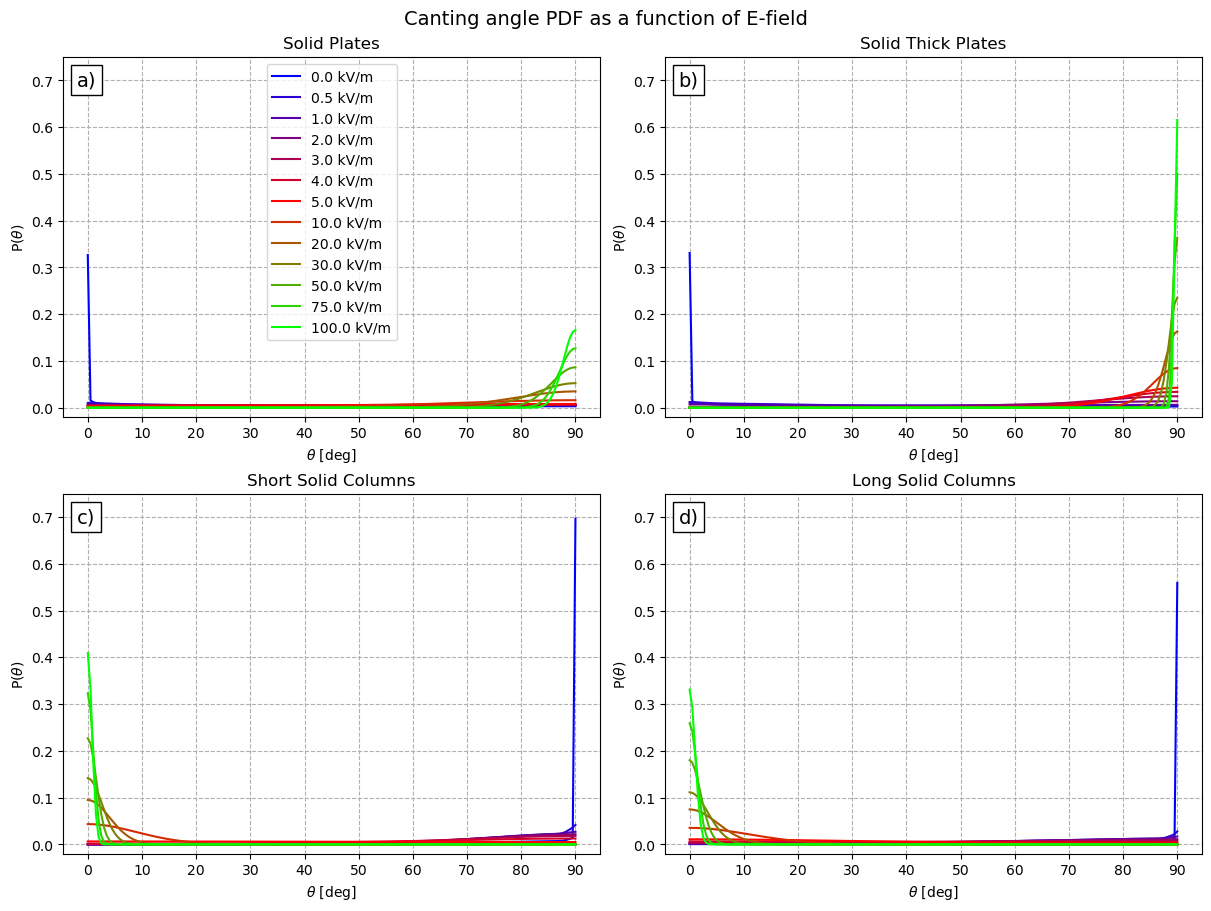

In [14]:
# plot the canting PDFs for both types of crystals and compare as function o E

import cycler

n = 13
color = plt.cm.brg(np.linspace(0, 1, n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']

fig, axs = plt.subplots(2, 2, figsize=[12, 9], constrained_layout = True)

for i in range(len(E)):
    axs.ravel()[0].plot(angles, get_b(pdfs[i])*np.mean(pdfs[i], 0), label = f'{E[i]/1e3} kV/m')
    axs.ravel()[0].set_title('Solid Plates')
    axs.ravel()[1].plot(angles, get_b(pdfs2[i])*np.mean(pdfs2[i], 0), label = f'{E[i]/1e3} kV/m')
    axs.ravel()[1].set_title('Solid Thick Plates')
    axs.ravel()[2].plot(angles, get_b(pdfs3[i])*np.mean(pdfs3[i], 0), label = f'{E[i]/1e3} kV/m')
    axs.ravel()[2].set_title('Short Solid Columns')
    axs.ravel()[3].plot(angles, get_b(pdfs4[i])*np.mean(pdfs4[i], 0), label = f'{E[i]/1e3} kV/m')
    axs.ravel()[3].set_title('Long Solid Columns')
    
axs.ravel()[0].legend()

for ax, L in zip(axs.ravel(), letters):
    ax.set_ylim(-.02, 0.75)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'P($\theta$)')
    ax.annotate(L, xy = (0.025, 0.92), xycoords = 'axes fraction', fontsize = 14, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.set_xticks(np.arange(0, 100, 10))
    ax.grid(True, ls = '--')


fig.suptitle(r'Canting angle PDF as a function of E-field', fontsize = 14)

plt.savefig('histograms.png', dpi = 300, bbox_inches='tight')

In [10]:
# get the mean and standard deviations of the canting angles
cantings = [get_canting(get_b(pdfs[i])*np.mean(pdfs[i], 0), angles) for i in range(len(E))] 
cantings2 = [get_canting(get_b(pdfs2[i])*np.mean(pdfs2[i], 0), angles) for i in range(len(E))]
cantings3 = [get_canting(get_b(pdfs3[i])*np.mean(pdfs3[i], 0), angles) for i in range(len(E))]
cantings4 = [get_canting(get_b(pdfs4[i])*np.mean(pdfs4[i], 0), angles) for i in range(len(E))]

In [ ]:
# scattering simulations function
def process_plates(N_0, D_0, theta, lam, m, alpha, beta, thin = True):
    """
    Perform the scattering simulations for plate-like particles.

    Parameters
    ----------
    N_0: array-like.
        PSD intercept parameter in m^-3.
    D_0: array-like.
        PSD slope parameter in m^-3.
    theta: 2D array-like.
        The mean and standard deviation.
    m: array-like.
        The complex refractive index.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
    thin: bool.
        If thin plates, use ndgs = 34.

    Returns
    -------
    results: dict.
         dictionary containing the Z_H, Z_V, Z_DR, K_DP, and LDR arrays.
    """
    
    results = {}

    if theta[0] < 0.004:
        sd = 0.004
    else:
        sd = theta[0]

    ga = gamma_plate(alpha, beta)
    axis_ratio_func = lambda D: 1 / ga(D)

    if thin is True:
        scatterer = Scatterer(wavelength=lam, m=m, ndgs=34)
    scatterer.psd_integrator = psd.PSDIntegrator()
    scatterer.psd_integrator.axis_ratio_func = axis_ratio_func
    scatterer.psd_integrator.D_max = 1.0
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)

    scatterer.or_pdf = orientation.gaussian_pdf(sd, theta[1])
    scatterer.orient = orientation.orient_averaged_fixed

    scatterer.psd_integrator.init_scatter_table(scatterer)

    scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
    scatterer.psd = expPSD(N_0, D_0)

    results["kdp"] = radar.Kdp(scatterer)

    scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
    results["zh"] = 10 * np.log10(radar.refl(scatterer))
    results["zv"] = 10 * np.log10(radar.refl(scatterer, h_pol=False))
    results["zdr"] = 10 * np.log10(radar.Zdr(scatterer))
    results["ldr"] = 10 * np.log10(radar.ldr(scatterer))

    return results

In [1]:
#define the slope and intercept parameters for the crystal PSDs
D0 = np.arange(0.3, 0.8, 0.1)
N0 = np.arange(2e4, 2.2e5, 2e4)

# Create all combinations
combinations = list(product(N0, D0, cantings))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_S, m_ice[2], 2.18, 0.415, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate = [r["kdp"] for r in results]
zdr_plate = [r["zdr"] for r in results]
zh_plate = [r["zh"] for r in results]
zv_plate = [r["zv"] for r in results]
ldr_plate = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.

zh_array = np.asarray(zh_plate).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file

myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

NameError: name 'np' is not defined

In [ ]:
# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_C, m_ice[1], 2.18, 0.415, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate = [r["kdp"] for r in results]
zdr_plate = [r["zdr"] for r in results]
zh_plate = [r["zh"] for r in results]
zv_plate = [r["zv"] for r in results]
ldr_plate = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.

zh_array = np.asarray(zh_plate).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file

myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_X, m_ice[0], 2.18, 0.415, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate = [r["kdp"] for r in results]
zdr_plate = [r["zdr"] for r in results]
zh_plate = [r["zh"] for r in results]
zv_plate = [r["zv"] for r in results]
ldr_plate = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.

zh_array = np.asarray(zh_plate).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file

myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [35]:
# Create all combinations
combinations = list(product(N0, D0, cantings2))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_S, m_ice[2], 1.07, 0.778, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate = [r["kdp"] for r in results]
zdr_plate = [r["zdr"] for r in results]
zh_plate = [r["zh"] for r in results]
zv_plate = [r["zv"] for r in results]
ldr_plate = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_plate).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file

myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate2_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

Scattering calculations: 100%|█████████████████████████████████████████████████████████████| 50000/50000 [2:14:01<00:00,  6.22it/s]


In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings2))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_C, m_ice[1], 1.07, 0.778, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate2 = [r["kdp"] for r in results]
zdr_plate2 = [r["zdr"] for r in results]
zh_plate2 = [r["zh"] for r in results]
zv_plate2 = [r["zv"] for r in results]
ldr_plate2 = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_plate2).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate2).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate2).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate2).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate2).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file

myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate2_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings2))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_plates)(N_0, D_0, theta, tmatrix_aux.wl_X, m_ice[0], 1.07, 0.778, True) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_plate2 = [r["kdp"] for r in results]
zdr_plate2 = [r["zdr"] for r in results]
zh_plate2 = [r["zh"] for r in results]
zv_plate2 = [r["zv"] for r in results]
ldr_plate2 = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_plate2).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_plate2).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_plate2).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_plate2).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_plate2).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_plate2_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [25]:
# Scattering wrapper
def process_columns(N_0, D_0, theta, lam, m, a, b):
    """
    Perform the scattering simulations for plate-like particles.

    Parameters
    ----------
    N_0: array-like.
        PSD intercept parameter in m^-3.
    D_0: array-like.
        PSD slope parameter in m^-3.
    theta: 2D array-like.
        The mean and standard deviation.
    m: array-like.
        The complex refractive index.
    alpha: int or float.
        Alpha parameter.
    beta: int or float.
        beta parameter.
    thin: bool.
        If thin plates, use ndgs = 34.

    Returns
    -------
    results: dict.
         dictionary containing the Z_H, Z_V, Z_DR, K_DP, and LDR arrays.
    """
    
    results = {}

    if theta[0] < 0.004:
        sd = 0.004
    else:
        sd = theta[0]

    ga = gamma_column(a, b)
    axis_ratio_func = lambda D: 1 / ga(D)

    scatterer = Scatterer(wavelength=lam, m=m)
    scatterer.psd_integrator = psd.PSDIntegrator()
    scatterer.psd_integrator.axis_ratio_func = axis_ratio_func
    scatterer.psd_integrator.D_max = 1.0
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)

    scatterer.or_pdf = orientation.gaussian_pdf(sd, theta[1])
    scatterer.orient = orientation.orient_averaged_fixed

    scatterer.psd_integrator.init_scatter_table(scatterer)

    scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
    scatterer.psd = expPSD(N_0, D_0)

    results["kdp"] = radar.Kdp(scatterer)

    scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
    results["zh"] = 10 * np.log10(radar.refl(scatterer))
    results["zv"] = 10 * np.log10(radar.refl(scatterer, h_pol=False))
    results["zdr"] = 10 * np.log10(radar.Zdr(scatterer))
    results["ldr"] = 10 * np.log10(radar.ldr(scatterer))

    return results

In [26]:
# Create all combinations
combinations = list(product(N0, D0, cantings3))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_S, m_ice[2], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column1_S2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

Scattering calculations:   0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings3))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_C, m_ice[1], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column1_C2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings3))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_X, m_ice[0], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column1_X2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings4))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_S, m_ice[2], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column2_S2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings4))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_C, m_ice[1], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column2_C2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
# Create all combinations
combinations = list(product(N0, D0, cantings4))

# Run in parallel
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_columns)(N_0, D_0, theta, tmatrix_aux.wl_X, m_ice[0], 0.85, 0.958) for N_0, D_0, theta in tqdm(combinations, desc="Scattering calculations", position=0, leave=True))

# Unpack results
kdp_column = [r["kdp"] for r in results]
zdr_column = [r["zdr"] for r in results]
zh_column = [r["zh"] for r in results]
zv_column = [r["zv"] for r in results]
ldr_column = [r["ldr"] for r in results]

#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_column).reshape((len(D_0), len(N_0), len(E)))
zv_array = np.asarray(zv_column).reshape((len(D_0), len(N_0), len(E)))
zdr_array = np.asarray(zdr_column).reshape((len(D_0), len(N_0), len(E)))
kdp_array = np.asarray(kdp_column).reshape((len(D_0), len(N_0), len(E)))
ldr_array = np.asarray(ldr_column).reshape((len(D_0), len(N_0), len(E)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_column2_X2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [28]:
# define graupel PSD parameters
rho_g = np.arange(0.300, 1.1, 0.2)
D0 = np.arange(0.8, 3.6, 0.4)
N0 = np.arange(1e2, 8e3, 6e2)

kdp_graupel = []
zdr_graupel = []
zh_graupel = []
zv_graupel = []
ldr_graupel = []

# Store the results in a structured way
results = []

for rho in rho_g:
    scatterer = Scatterer(wavelength=tmatrix_aux.wl_S, m=refractive.mi(tmatrix_aux.wl_S, rho), axis_ratio=1/0.75)
    scatterer.psd_integrator = psd.PSDIntegrator()
    scatterer.psd_integrator.D_max = 10
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    scatterer.or_pdf = orientation.gaussian_pdf(45, 0)
    scatterer.orient = orientation.orient_averaged_fixed
    scatterer.psd_integrator.init_scatter_table(scatterer)

    for N_0 in N0:
        for D_0 in D0:
            scatterer.psd = expPSD(N_0, D_0)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
            kdp = radar.Kdp(scatterer)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
            zh = 10 * np.log10(radar.refl(scatterer))
            zv = 10 * np.log10(radar.refl(scatterer, h_pol=False))
            zdr = 10 * np.log10(radar.Zdr(scatterer))
            ldr = 10 * np.log10(radar.ldr(scatterer))
            
            kdp_graupel.append(kdp)
            zh_graupel.append(zh)
            zv_graupel.append(zv)
            zdr_graupel.append(zdr)
            ldr_graupel.append(ldr)

Processing density: 0.300 g/cm^3
Processing density: 0.500 g/cm^3
Processing density: 0.700 g/cm^3
Processing density: 0.900 g/cm^3


In [29]:
#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_graupel).reshape((len(rho_g), len(N0), len(D0)))
zv_array = np.asarray(zv_graupel).reshape((len(rho_g), len(N0), len(D0)))
zdr_array = np.asarray(zdr_graupel).reshape((len(rho_g), len(N0), len(D0)))
kdp_array = np.asarray(kdp_graupel).reshape((len(rho_g), len(N0), len(D0)))
ldr_array = np.asarray(ldr_graupel).reshape((len(rho_g), len(N0), len(D0)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_graupel_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
kdp_graupel = []
zdr_graupel = []
zh_graupel = []
zv_graupel = []
ldr_graupel = []

# Store the results in a structured way
results = []

for rho in rho_g:
    scatterer = Scatterer(wavelength=tmatrix_aux.wl_C, m=refractive.mi(tmatrix_aux.wl_C, rho), axis_ratio=1/0.75)
    scatterer.psd_integrator = psd.PSDIntegrator()
    scatterer.psd_integrator.D_max = 10
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    scatterer.or_pdf = orientation.gaussian_pdf(45, 0)
    scatterer.orient = orientation.orient_averaged_fixed
    scatterer.psd_integrator.init_scatter_table(scatterer)

    for N_0 in N0:
        for D_0 in D0:
            scatterer.psd = expPSD(N_0, D_0)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
            kdp = radar.Kdp(scatterer)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
            zh = 10 * np.log10(radar.refl(scatterer))
            zv = 10 * np.log10(radar.refl(scatterer, h_pol=False))
            zdr = 10 * np.log10(radar.Zdr(scatterer))
            ldr = 10 * np.log10(radar.ldr(scatterer))
            
            kdp_graupel.append(kdp)
            zh_graupel.append(zh)
            zv_graupel.append(zv)
            zdr_graupel.append(zdr)
            ldr_graupel.append(ldr)

In [ ]:
#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_graupel).reshape((len(rho_g), len(N0), len(D0)))
zv_array = np.asarray(zv_graupel).reshape((len(rho_g), len(N0), len(D0)))
zdr_array = np.asarray(zdr_graupel).reshape((len(rho_g), len(N0), len(D0)))
kdp_array = np.asarray(kdp_graupel).reshape((len(rho_g), len(N0), len(D0)))
ldr_array = np.asarray(ldr_graupel).reshape((len(rho_g), len(N0), len(D0)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_graupel_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [ ]:
kdp_graupel = []
zdr_graupel = []
zh_graupel = []
zv_graupel = []
ldr_graupel = []

# Store the results in a structured way
results = []

for rho in rho_g:
    scatterer = Scatterer(wavelength=tmatrix_aux.wl_X, m=refractive.mi(tmatrix_aux.wl_X, rho), axis_ratio=1/0.75)
    scatterer.psd_integrator = psd.PSDIntegrator()
    scatterer.psd_integrator.D_max = 10
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    scatterer.or_pdf = orientation.gaussian_pdf(45, 0)
    scatterer.orient = orientation.orient_averaged_fixed
    scatterer.psd_integrator.init_scatter_table(scatterer)

    for N_0 in N0:
        for D_0 in D0:
            scatterer.psd = expPSD(N_0, D_0)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
            kdp = radar.Kdp(scatterer)
            scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
            zh = 10 * np.log10(radar.refl(scatterer))
            zv = 10 * np.log10(radar.refl(scatterer, h_pol=False))
            zdr = 10 * np.log10(radar.Zdr(scatterer))
            ldr = 10 * np.log10(radar.ldr(scatterer))
            
            kdp_graupel.append(kdp)
            zh_graupel.append(zh)
            zv_graupel.append(zv)
            zdr_graupel.append(zdr)
            ldr_graupel.append(ldr)

In [ ]:
#reshape our results so they are depend on the shapes of D_0, N_0 and E.
zh_array = np.asarray(zh_graupel).reshape((len(rho_g), len(N0), len(D0)))
zv_array = np.asarray(zv_graupel).reshape((len(rho_g), len(N0), len(D0)))
zdr_array = np.asarray(zdr_graupel).reshape((len(rho_g), len(N0), len(D0)))
kdp_array = np.asarray(kdp_graupel).reshape((len(rho_g), len(N0), len(D0)))
ldr_array = np.asarray(ldr_graupel).reshape((len(rho_g), len(N0), len(D0)))

#save the output as a pickle file
myvar = [{'zh': zh_array, 'zv': zv_array, 'zdr': zdr_array, 'kdp': kdp_array, 'ldr': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_graupel_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

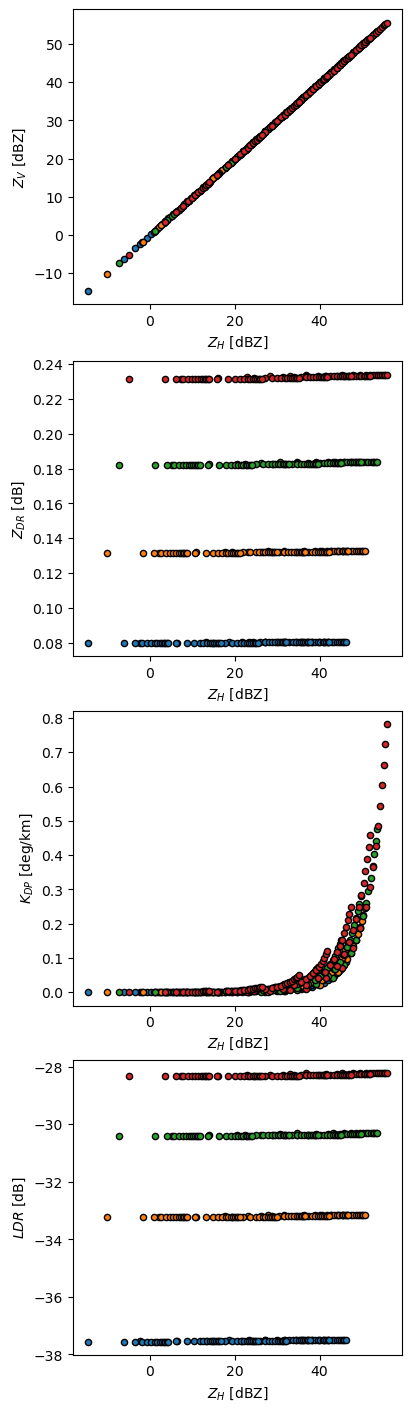

In [30]:
#make plots to check

fig, axs = plt.subplots(2,2, figsize=[4,14], constrained_layout = True)

[axs.ravel()[0].scatter(zh, zv, s=20, edgecolor='k') for zh,zv in zip(zh_array, zv_array)]
axs.ravel()[0].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[0].set_ylabel(r'$Z_{V}$ [dBZ]')
[axs.ravel()[1].scatter(zh, zdr, s=20, edgecolor='k') for zh,zdr in zip(zh_array, zdr_array)]
axs.ravel()[1].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[1].set_ylabel(r'$Z_{DR}$ [dB]')
[axs.ravel()[2].scatter(zh, kdp, s=20, edgecolor='k') for zh,kdp in zip(zh_array, kdp_array)]
axs.ravel()[2].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[2].set_ylabel(r'$K_{DP}$ [deg/km]')
[axs.ravel()[3].scatter(zh, ldr, s=20, edgecolor='k') for zh,ldr in zip(zh_array, ldr_array)]
axs.ravel()[3].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[3].set_ylabel(r'$LDR$ [dB]')

plt.savefig('graupel_old.png', dpi=300, bbox_inches='tight')

In [69]:
# define snow PSD parameters
D0 = np.arange(0.8, 3.6, 0.4)
N0 = np.arange(1e2, 8e3, 6e2)

e_a = 1.00059+0j

kdp_snow = []
zh_snow = []
zv_snow = []
ldr_snow = []
zdr_snow = []
for N_0 in N0:
    for D_0 in D0:
        scatterer = Scatterer(wavelength=tmatrix_aux.wl_S, axis_ratio=1/0.75)
        scatterer.psd_integrator = psd.PSDIntegrator()
        scatterer.psd_integrator.D_max = 15
        scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
        scatterer.psd_integrator.m_func = m_agg(lam = tmatrix_aux.wl_S)
        
        scatterer.or_pdf = orientation.gaussian_pdf(20, 0)
        scatterer.orient = orientation.orient_averaged_fixed
        scatterer.psd_integrator.init_scatter_table(scatterer)
        scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
        scatterer.psd = expPSD(N_0, D_0)
        
        kdp_snow.append(radar.Kdp(scatterer))
        scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
        zh_snow.append(10*np.log10(radar.refl(scatterer)))
        zv_snow.append(10*np.log10(radar.refl(scatterer, False)))
        ldr_snow.append(10*np.log10(radar.ldr(scatterer)))
        zdr_snow.append(10*np.log10(radar.Zdr(scatterer)))


KeyboardInterrupt



In [ ]:
zh_array = np.asarray(zh_snow).reshape((len(N0), len(D0))).T
zv_array = np.asarray(zv_snow).reshape((len(N0), len(D0))).T
zdr_array = np.asarray(zdr_snow).reshape((len(N0), len(D0))).T
kdp_array = np.asarray(kdp_snow).reshape((len(N0), len(D0))).T
ldr_array = np.asarray(ldr_snow).reshape((len(N0), len(D0))).T

In [ ]:
fig, axs = plt.subplots(2,2, figsize=[8,7], constrained_layout = True)

[axs.ravel()[0].scatter(zh, zv, s=20, edgecolor='k') for zh,zv in zip(zh_array, zv_array)]
axs.ravel()[0].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[0].set_ylabel(r'$Z_{V}$ [dBZ]')
[axs.ravel()[1].scatter(zh, zdr, s=20, edgecolor='k') for zh,zdr in zip(zh_array, zdr_array)]
axs.ravel()[1].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[1].set_ylabel(r'$Z_{DR}$ [dB]')
[axs.ravel()[2].scatter(zh, kdp, s=20, edgecolor='k') for zh,kdp in zip(zh_array, kdp_array)]
axs.ravel()[2].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[2].set_ylabel(r'$K_{DP}$ [$^{\circ}$ km$^{-1}$]')
[axs.ravel()[3].scatter(zh, ldr, s=20, edgecolor='k') for zh,ldr in zip(zh_array, ldr_array)]
axs.ravel()[3].set_xlabel(r'$Z_{H}$ [dB]')
axs.ravel()[3].set_ylabel(r'$LDR$ [dB]')

In [ ]:
import pickle

myvar = [{'zh_snow': zh_array, 'zv_snow': zv_array, 'zdr_snow': zdr_array, 'kdp_snow': kdp_array, 'ldr_snow': ldr_array}] 

#Open a file and use dump() 
with open('sim_full_snow_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [69]:
import pickle

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column2_X2.pkl',mode='rb') as f:
    data_plate = pickle.load(f)[0]

In [70]:
myvar = [{'zh': data_plate['zh_plate'], 'zv': data_plate['zv_plate'], 'zdr': data_plate['zdr_plate'], 'kdp': data_plate['zdr_plate'], 'ldr': data_plate['ldr_plate']}] 

In [71]:
#Open a file and use dump() 
with open('sim_full_column1_X3.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [72]:
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column1_X3.pkl',mode='rb') as f:
    data_plate = pickle.load(f)[0]

In [64]:
data_plate

{'zh': array([[[-10.88981644, -11.07437586, -11.08851245, ..., -13.07161067,
          -13.07161337, -13.07161606],
         [ -2.8744448 ,  -3.06064566,  -3.07491032, ...,  -5.07861424,
           -5.07861697,  -5.07861969],
         [  2.61712229,   2.43008452,   2.41575454, ...,   0.40151813,
            0.40151539,   0.40151266],
         ...,
         [  5.62742225,   5.44038448,   5.4260545 , ...,   3.41181809,
            3.41181535,   3.41181262],
         [  9.54867121,   9.36116519,   9.34679866, ...,   7.32666188,
            7.32665913,   7.32665638],
         [ 12.46324104,  12.27544631,  12.26105725, ...,  10.23728023,
           10.23727747,  10.23727473]],
 
        [[ -6.11860389,  -6.30316332,  -6.3172999 , ...,  -8.30039813,
           -8.30040082,  -8.30040351],
         [  1.89676774,   1.71056689,   1.69630223, ...,  -0.3074017 ,
           -0.30740442,  -0.30740714],
         [  7.38833484,   7.20129707,   7.18696709, ...,   5.17273068,
            5.17272794,   